# Lecture: Complex Network Analysis

Prof. Dr. Michael Gertz

Winter Semester 2021/22

## Assignment 8 - Clustering and Modularity

### Problem 8-1: European Power Grid

Students: Felix Hausberger, Nils Krehl, Patrick Günther

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
df = pd.read_csv('gridkit_europe.csv')
df.drop(columns=[col for col in df if col not in ["v_id_1", "v_id_2"]], inplace=True)
df.head()

,v_id_1,v_id_2
0,43193,23620
1,42022,13686
2,6913,48526
3,35422,28973
4,7864,63104


In [16]:
# since it is an undirected graph, no parallel edges are added
G = nx.Graph()
G.add_edges_from(df.itertuples(index=False))

# remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

# stats
print(f"N = {G.number_of_nodes()}")
print(f"N = {G.number_of_edges()}")

N = 13844
N = 17277


# 1.

In [24]:
def nth_moment(G, n):
    degrees = np.array(list(dict(G.degree).values()))
    return (sum(degrees**n)/len(G))

K = nth_moment(G, 2) / nth_moment(G, 1)
print(f"Molloy-Reed criterion: K = {np.round(K, 2)}")

Molloy-Reed criterion: K = 3.16


Since $K$ is bigger than 2, the european power grid network should have a giant component. This makes complete sense in the case of a power grid network, since there shouldn't be fragmented infrastructure for power supply.

# 2.

In [75]:
def size_largest_component(G):
    if G.number_of_nodes() > 0:
        return len(max(nx.connected_components(G), key=len))
    return 0

def average_size_components(G):
    if G.number_of_nodes() > 0:
        component_sizes = [len(component) for component in sorted(nx.connected_components(G), key=len, reverse=True)]
        return sum(component_sizes) / len(component_sizes)
    return 0

print(f"Absolute size of largest component: {size_largest_component(G)}")
print(f"Relative size of largest component: {np.round(size_largest_component(G) / G.number_of_nodes(), 2)}")

Absolute size of largest component: 13478
Relative size of largest component: 0.97


Yes, the Molloy-Reed criterion gives the correct prediction as 97% of the nodes are inside a giant component.

# 3.

In [53]:
print(f"f_c: {np.round(1 - (1 / (K - 1)), 2)}")
print(f"f_c_er: {np.round(1 - (1 / K), 2)}")

f_c: 0.54
f_c_er: 0.68


As $f_c < f_c^{ER}$ the european power grid network does not own enhanced robustness against random failures as its critical breakdown threshold is lower than expected for a random network with the same degree distribution. 

# 4.

In [71]:
def sample_random_failures(G, num_samples=10):
    N = G.number_of_nodes()
        
    averaged_largest_component_size = []
    averaged_average_component_size = []  
    for f_c in np.arange(0, 1.1, 0.1):
        largest_component_size = []
        average_component_size = []
        for sample in range(num_samples):
            G_fc = G.copy()
            number_to_be_removed = int(np.round(f_c * N))
            nodes_to_be_removed = np.random.choice(G_fc.nodes(), number_to_be_removed, replace=False)
            G_fc.remove_nodes_from(nodes_to_be_removed)
            largest_component_size.append(size_largest_component(G_fc))
            average_component_size.append(average_size_components(G_fc))
        
        averaged_largest_component_size.append(np.mean(np.array(largest_component_size)))
        averaged_average_component_size.append(np.mean(np.array(average_component_size)))
    return np.array(averaged_largest_component_size), np.array(averaged_average_component_size)

max_component_sizes, average_component_sizes = sample_random_failures(G)

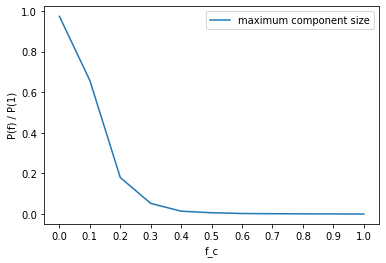

In [72]:
N = G.number_of_nodes()
plt.plot(max_component_sizes / N, label="maximum component size")
plt.xticks(ticks=range(11), labels=(np.arange(0, 11, 1) / 10))
plt.legend()
plt.xlabel("f_c")
plt.ylabel("P(f) / P(1)")
plt.show()

One recognizes that at $f_c = 0.54$ the size of the largest component converges to 1 as predicted. This means for a power grid to lose its complete functionality to supply power around 50% of nodes need to randomly fail to achieve a collapse of the network. 

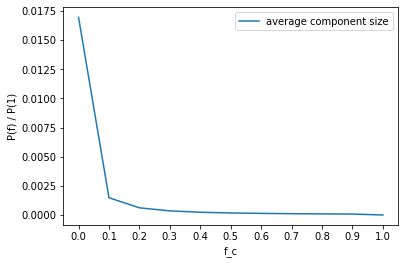

In [74]:
N = G.number_of_nodes()
plt.plot(average_component_sizes / N, label="average component size")
plt.xticks(ticks=range(11), labels=(np.arange(0, 11, 1) / 10))
plt.legend()
plt.xlabel("f_c")
plt.ylabel("P(f) / P(1)")
plt.show()

Already when 10% of all nodes randomly fail, one recognizes that the size of the largest component has drastically decreased and that also the average component size begins to converge to 1.